In [31]:
# The goal of this lab is to study Fourier analysis and provide some hands-on experience with image restoration concepts in frequency domain as well as filter design.

import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.transform import rotate
from skimage.color import rgb2gray
from skimage.morphology import disk
from skimage.metrics import peak_signal_noise_ratio as PSNR
import skimage.util
from scipy import signal
from typing import Dict


def gaussian_filter(n_rows, n_cols, stdv):
    """
    Returns a 2d Gaussian image filter.
    """
    g_r = signal.windows.gaussian(n_rows, stdv)
    g_c = signal.windows.gaussian(n_cols, stdv)

    G = np.outer(g_r, g_c)

    return G/np.sum(G)

plt.gray()
lena= rgb2gray(imread('lena.tiff'))
frequnoisy = imread('frequnoisy.tif').astype(np.float64)/255

def plot_images(images: Dict[str, np.ndarray], title=None, cmap='None'):
    """Plots all images in a row""",
    fig = plt.figure(figsize=(12, 4))
    for index, (subtitle, image) in enumerate(images.items(), 1):
        ax = fig.add_subplot(1, len(images), index)
        if cmap == 'gray':
            ax.imshow(image, cmap='gray')
        else:
            ax.imshow(image)
        ax.title.set_text(subtitle)
    if title:
        fig.suptitle(title)
    plt.show()

<Figure size 640x480 with 0 Axes>

# Part 2: Fourier Analysis

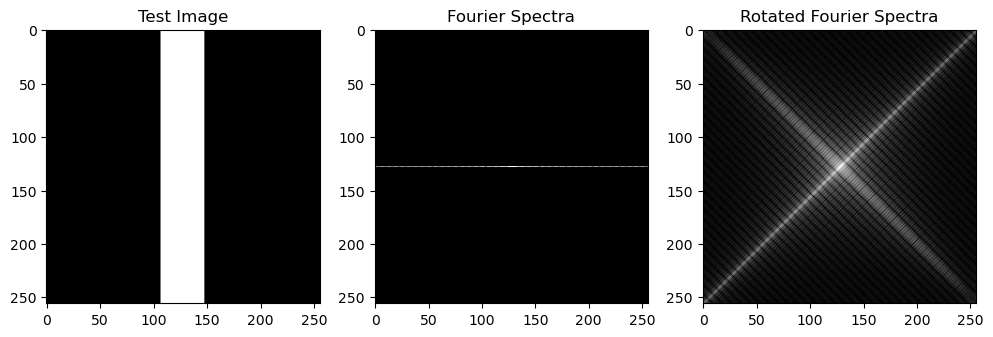

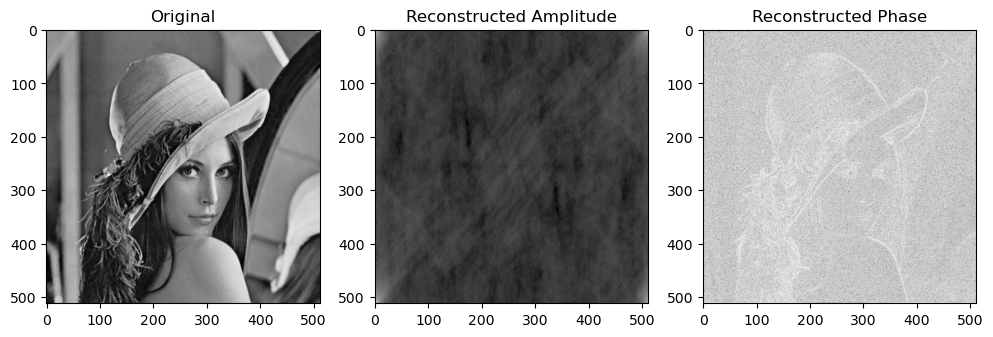

In [32]:
# Let us now study the characteristics of an image in frequency domain. For this study, we will create a new 256×256 test image, which consists of a white rectangle.

f = np.zeros((256,256))
f[:,107:148] = 1

# Now plot the Fourier spectra of the image. Be sure to use the cmap = ‘gray‘ argument in the plt.imshow funtion. The np.fft2, np.fftshift, and np.abs functions will be useful here.
F = np.fft.fftshift(np.fft.fft2(f))

# Now rotate the test image by 45 degrees and plot both the Fourier spectra and the image. use the skimage.transform.rotate function.
f_rot = rotate(f, 45)
F_rot = np.fft.fftshift(np.fft.fft2(f_rot))

# plot the two
plot_images({'Test Image': f, 'Fourier Spectra': np.log(1+abs(F)), 'Rotated Fourier Spectra': np.log(1+abs(F_rot))}, cmap='gray')

# Now let us study the contribution of Fourier amplitude and phase to the underlying image. Load the Lena image and convert it to a grayscale image using the skimage.color.rgb2gray function. (lena)

# Now compute the amplitude and phase of the Lena image. Remember that the amplitude component A is the magnitude of the Fourier complex component (use the np.abs function) and the phase component θ can be found by simply dividing the Fourier component F (w) by the amplitude A since F(w) = A ∗ (cos(θ) + j sin(θ))

F = np.fft.fftshift(np.fft.fft2(lena))
A = np.abs(F)
theta = np.angle(F)

fixed_phase = 0
fixed_amplitude = 1

# Now perform the inverse Fourier transform on the amplitude component A and the phase component θ separately. np.fft.ifft2 and np.fft.ifftshift will come in handy.
#  Plot the original image, the reconstructed image (lena) using just the amplitude component, and the reconstructed image using just the phase component.

fourier_component_amplitude = A*(np.cos(fixed_phase) + 1j*np.sin(fixed_phase))
lena_reconstructed_amplitude = np.fft.ifft2(np.fft.ifftshift(fourier_component_amplitude))

fourier_component_phase = fixed_amplitude*(np.cos(theta) + 1j*np.sin(theta))
lena_reconstructed_phase = np.fft.ifft2(np.fft.ifftshift(fourier_component_phase))

#plot

plot_images({'Original': lena, 'Reconstructed Amplitude': np.log(abs(lena_reconstructed_amplitude)), 'Reconstructed Phase': np.log(abs(lena_reconstructed_phase)) }, cmap='gray')



# Part 3: Noise Reduction in the Frequency Domain

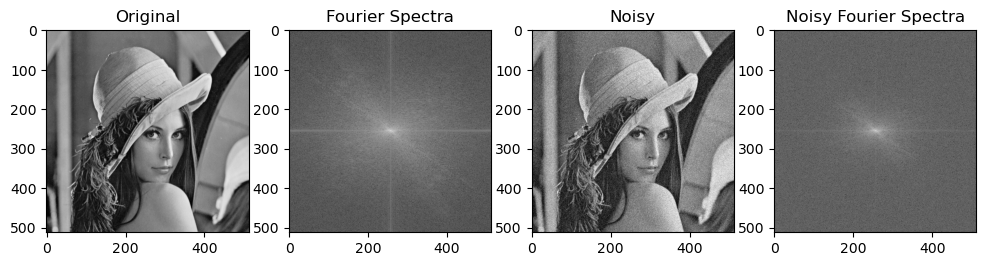

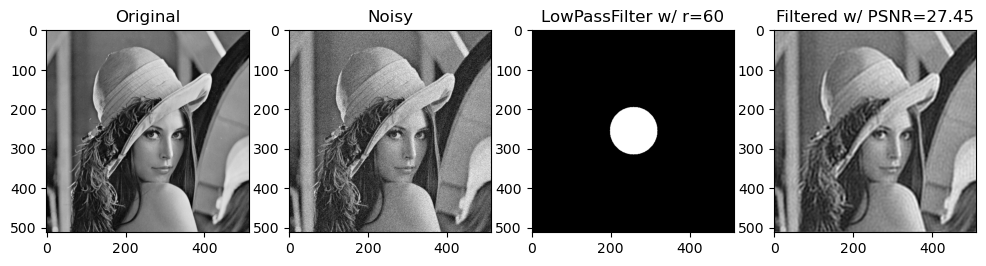

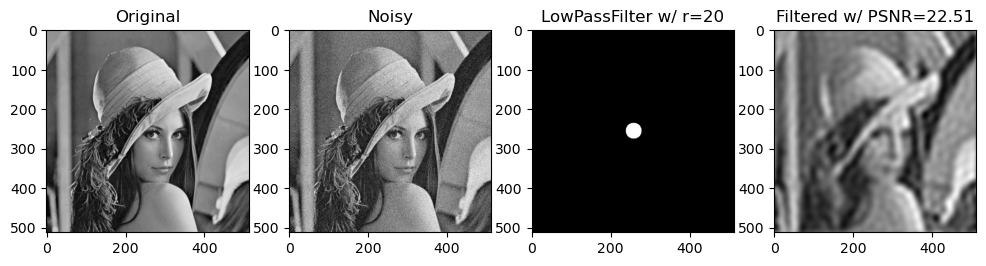

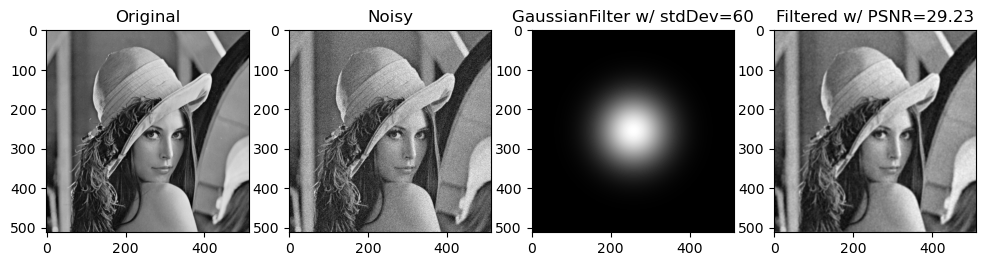

In [59]:
# # intensity test
# min = lena.min()
# max = lena.max()
# print(min, max) # 0.0 1.0

# Load the Lena image (adjust intensities to range of 0 to 1) and apply additive Gaussian noise with variance of 0.005 to the image.
noisy_lena = skimage.util.random_noise(lena, mode='gaussian', mean=0,var=0.005)
# Plot the Log Fourier spectra of the original image and the noisy image by using the np.log function on the Fourier spectra.
F_lena = np.fft.fftshift(np.fft.fft2(lena))
F_noisy_lena = np.fft.fftshift(np.fft.fft2(noisy_lena))
plot_images({'Original': lena, 'Fourier Spectra': np.log(abs(F_lena)), 'Noisy': noisy_lena, 'Noisy Fourier Spectra': np.log(abs(F_noisy_lena))}, cmap='gray')
#NOTE I cannot see the differences between the two from above at all

# Create and plot the Fourier spectra of the resulting low-pass filter h_freq with a radius of 60
r=60
h = disk(r)
h_freq = np.zeros(lena.shape)
height, width = lena.shape
h_freq[height//2-r: height//2+r+1, width//2-r: width//2+r+1] = h

# apply filter to the noisy image in the frequency domain 
F_filtered = F_noisy_lena*h_freq
# inverse fourier transform
filtered_lena = np.fft.ifft2(np.fft.ifftshift(F_filtered))
# plot the resulting denoised image and the corresponding PSNR
psnr1 = round(PSNR(lena, filtered_lena.real), 2)
plot_images({'Original': lena, 'Noisy': noisy_lena, 'LowPassFilter w/ r=60': h_freq, 'Filtered w/ PSNR=' + str(psnr1): filtered_lena.real}, cmap='gray')

# Create and plot the Fourier spectra of the resulting low-pass filter h_freq with a radius of 20
r2=20
h2 = disk(r2)
h_freq2 = np.zeros(lena.shape)
height, width = lena.shape
h_freq2[height//2-r2: height//2+r2+1, width//2-r2: width//2+r2+1] = h2

# apply filter to the noisy image in the frequency domain 
F_filtered2 = F_noisy_lena*h_freq2
# inverse fourier transform
filtered_lena2 = np.fft.ifft2(np.fft.ifftshift(F_filtered2))
# plot the resulting denoised image and the corresponding PSNR
psnr2 = round(PSNR(lena, filtered_lena2.real), 2)
plot_images({'Original': lena, 'Noisy': noisy_lena, 'LowPassFilter w/ r=20': h_freq2, 'Filtered w/ PSNR=' + str(psnr2): filtered_lena2.real}, cmap='gray')

#  Gaussian filter with std dev of 60
G = gaussian_filter(height, width, 60)
# normalize G
G = G/G.max()

# apply filter to the noisy image in the frequency domain and plot
F_filtered3 = F_noisy_lena*G
# inverse fourier transform
filtered_lena3 = np.fft.ifft2(np.fft.ifftshift(F_filtered3))
# plot the resulting denoised image and the corresponding PSNR
psnr3 = round(PSNR(lena, filtered_lena3.real), 2)
plot_images({'Original': lena, 'Noisy': noisy_lena, 'GaussianFilter w/ stdDev=60': G, 'Filtered w/ PSNR=' + str(psnr3): filtered_lena3.real}, cmap='gray')


# Part 4: Filter Design

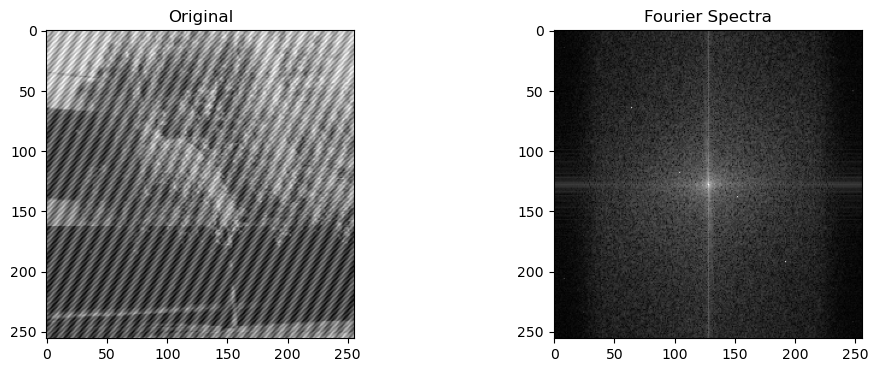

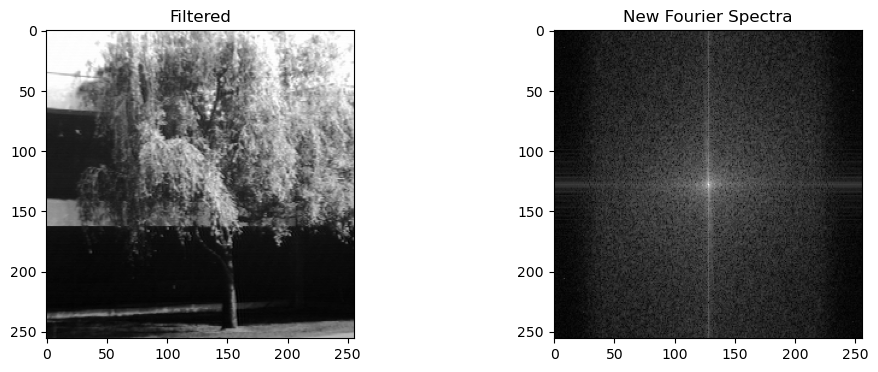

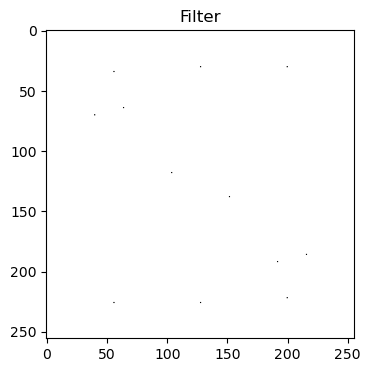

In [34]:
from skimage.feature import peak_local_max

# Examine the frequnoisy image and its Fourier spectrum.
frequnoisy_fft = np.fft.fftshift(np.fft.fft2(frequnoisy))
temp = np.copy(frequnoisy_fft)

# Note the peaks in the spectrum corresponding to the periodic noise source, which has been added to the original image. 
# Design and implement a frequency domain filter which filters out this noise. 

# Identify local maxima
max_coords = peak_local_max(abs(frequnoisy_fft), min_distance=20)
# remove center peak

for coord in max_coords:
    dist_to_origin = np.sqrt((coord[0]-128)**2 + (coord[1]-128)**2)
    index = np.where(max_coords == coord)[0][0]
    if dist_to_origin < 10:
        max_coords = np.delete(max_coords, index, axis=0)

# print(max_coords)

# Create a filter which is 1 everywhere except at the coordinates of the peak frequencies, where it is 0.
filter = np.ones(frequnoisy_fft.shape)
for x, y in max_coords:
    filter[(x,y)] = 0

# Now we can apply this filter to the Fourier spectrum of the noisy image to obtain the filtered image.
frequnoisy_filtered = np.fft.ifft2(np.fft.ifftshift(frequnoisy_fft*filter))
temp_new = np.fft.ifft2(np.fft.ifftshift(temp))

frequnoisy_filtered_fft = np.fft.fftshift(np.fft.fft2(frequnoisy_filtered))

plot_images({'Original': frequnoisy, 'Fourier Spectra': np.log(1+abs(frequnoisy_fft)) }, cmap='gray')

plot_images({'Filtered': abs(frequnoisy_filtered), 'New Fourier Spectra': np.log(1+abs(frequnoisy_filtered_fft))
}, cmap='gray')

plot_images({'Filter': filter}, cmap='gray')

In [35]:
a = np.array([1, 2, 3, 4, 5])

print(np.where(a == 5)[0][0])

4
